# **Machine Learning Assignment 2**
## **Colon Cancer Classification**

**Merve-Nur Soylu** | s3794687  
**Sefa Nur Soylu** | s3794642  

---

## **Introduction**

- Early and accurate detection of colon cancer plays a critical role in improving patient outcomes.
- In this project, we use the **CRCHistoPhenotypes** dataset, which consists of labeled colon histopathology image patches.
- The dataset supports two tasks:
  - **Task 1**: Binary classification — cancerous vs. not cancerous
  - **Task 2**: Multi-class classification — cell type (fibroblast, inflammatory, epithelial, others)
- This notebook focuses on **Task 1**.
- Our goal is to build an end-to-end deep learning pipeline using CNNs, justify each design choice, and evaluate performance thoroughly using relevant metrics.

---

## **Data Overview and Preprocessing**

- We use both the **main** and **extra** parts of the CRCHistoPhenotypes dataset, totaling **99 patients**.
- Each sample is an image patch with an associated label indicating whether it's **cancerous**.
- We perform the following steps:

### **Preprocessing Steps**
- **Image Resizing**: All images are resized to **27×27** pixels.
- **Normalization**: Images are converted to float32 and scaled to the range `[0, 1]`.
- **Stratified Splitting**:
  - Task 1: stratified by `isCancerous`, split into **70% train**, **15% validation**, **15% test**.
  - Task 2: stratified by `cellType`, using only the first 60 patients.
- **Image Augmentation**:
  - Applied only during training via `ImageDataGenerator`, including **horizontal flip, rotation, zoom, and shift**.
  - This boosts model generalization and helps prevent overfitting.
  - Augmentation resulted in **faster convergence** and **higher validation accuracy**.

---

In [114]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# ------------------- Load and preprocess data -------------------

# Load label files
main_labels = pd.read_csv('data_labels_mainData.csv')
extra_labels = pd.read_csv('data_labels_extraData.csv')
combined_labels = pd.concat([main_labels, extra_labels], ignore_index=True)

# Image folder
image_folder = "C:/Users/golde/Downloads/Image_classification_data/patch_images"

# Task 1: Cancerous classification (all data)
train_labels_t1, temp_labels_t1 = train_test_split(
    combined_labels, test_size=0.3, random_state=42, stratify=combined_labels['isCancerous']
)
val_labels_t1, test_labels_t1 = train_test_split(
    temp_labels_t1, test_size=0.5, random_state=42, stratify=temp_labels_t1['isCancerous']
)

# Task 2: Cell type classification (main dataset only)
train_labels_t2, temp_labels_t2 = train_test_split(
    main_labels, test_size=0.3, random_state=42, stratify=main_labels['cellType']
)
val_labels_t2, test_labels_t2 = train_test_split(
    temp_labels_t2, test_size=0.5, random_state=42, stratify=temp_labels_t2['cellType']
)

# Helper to load and preprocess images
def load_images(df, image_folder):
    images = []
    for img_name in df['ImageName']:
        img_path = os.path.join(image_folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            images.append(None)
    return images

def preprocess_images(image_list):
    image_list = [img for img in image_list if img is not None]
    return np.array([np.asarray(img, dtype=np.float32) / 255.0 for img in image_list])

# Task 1 image processing
train_images_t1 = preprocess_images(load_images(train_labels_t1, image_folder))
val_images_t1 = preprocess_images(load_images(val_labels_t1, image_folder))
test_images_t1 = preprocess_images(load_images(test_labels_t1, image_folder))

# Task 2 image processing
train_images_t2 = preprocess_images(load_images(train_labels_t2, image_folder))
val_images_t2 = preprocess_images(load_images(val_labels_t2, image_folder))
test_images_t2 = preprocess_images(load_images(test_labels_t2, image_folder))

# Labels
y_train_t1 = train_labels_t1['isCancerous'].values.astype(np.float32)
y_val_t1 = val_labels_t1['isCancerous'].values.astype(np.float32)
y_test_t1 = test_labels_t1['isCancerous'].values.astype(np.float32)

y_train_t2 = to_categorical(train_labels_t2['cellType'].values)
y_val_t2 = to_categorical(val_labels_t2['cellType'].values)
y_test_t2 = to_categorical(test_labels_t2['cellType'].values)

## **Model Design and Justification**

- We use a **Convolutional Neural Network (CNN)** for this task because CNNs are highly effective at learning spatial features from image data — especially in medical imaging, where local textures and patterns matter.
- The model architecture:
  - Two convolution layers (32, 64 filters) with `ReLU` activations
  - A MaxPooling layer after the first convolution to reduce spatial dimensions and help generalization
  - A Dense layer with `Dropout` (rate = 0.5) to reduce overfitting
  - Final layer with a `sigmoid` activation for binary classification (cancerous vs not cancerous)
- We use `binary_crossentropy` as the loss function and the `Adam` optimizer for efficient gradient-based optimization.
- **Class weights** are used during training to counter the imbalance between cancerous and non-cancerous samples. By assigning higher weight to the minority class, we help the model improve **recall**, which is critical in medical contexts where missing a positive case is costly.
---

In [146]:
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_t1),
    y=y_train_t1.astype(int)
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Define CNN
model_t1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_t1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

model_t1.summary()

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
datagen.fit(train_images_t1)

early_stopping = EarlyStopping(
    monitor='val_recall',
    patience=5,
    restore_best_weights=True,
    mode='max',
)

# Train
history = model_t1.fit(
    datagen.flow(train_images_t1, y_train_t1, batch_size=32),
    validation_data=(val_images_t1, y_val_t1),
    epochs=50,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Class weights: {0: 0.7675173010380623, 1: 1.4345189975747776}


C:\Users\golde\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 25, 25, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 429,121 (1.64 MB)

 Trainable params: 429,121 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\golde\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


444/444 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7172 - loss: 0.5522 - recall_1: 0.6546 - val_accuracy: 0.8320 - val_loss: 0.3717 - val_recall_1: 0.5830
Epoch 2/50
  2/444 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.8047 - loss: 0.3999 - recall_1: 0.4191 

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,recall_1,val_accuracy,val_loss,val_recall_1
  current = self.get_monitor_value(logs)


444/444 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.8101 - loss: 0.4307 - recall_1: 0.8079 - val_accuracy: 0.8544 - val_loss: 0.3566 - val_recall_1: 0.8792
Epoch 3/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.8254 - loss: 0.4045 - recall_1: 0.8147 - val_accuracy: 0.8688 - val_loss: 0.3456 - val_recall_1: 0.8764
Epoch 4/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.8217 - loss: 0.4069 - recall_1: 0.8185 - val_accuracy: 0.8521 - val_loss: 0.3840 - val_recall_1: 0.8557
Epoch 5/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.8360 - loss: 0.3855 - recall_1: 0.8281 - val_accuracy: 0.8389 - val_loss: 0.3929 - val_recall_1: 0.9302
Epoch 6/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.8373 - loss: 0.3726 - recall_1: 0.8417 - val_accuracy: 0.8580 - val_loss: 0.3522 - val_recall_1: 0.9047
Epoch 7/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.8501 - loss: 0.3625 - recall_1: 0.8368 - val_accuracy: 0.8800 - val_loss: 0.3075 - 

## **Training Setup and Evaluation Strategy**

- **Data Splits**: Stratified into Train (70%), Validation (15%), and Test (15%) to preserve class balance.
- **Augmentation**: Used real-time image augmentation (`ImageDataGenerator`) to improve generalization. Includes random rotations, shifts, zooms, and horizontal flipping.
- **Early Stopping**: Training monitored `val_recall` and **automatically stopped if recall plateaued for 5 epochs**, restoring the best weights. This helps:
  - Prevent overfitting
  - Maintain strong cancer detection (recall)
- **Evaluation Metrics**: Accuracy, Precision, Recall, and F1-score, reported per class to assess both overall performance and cancer-specific behavior.
---

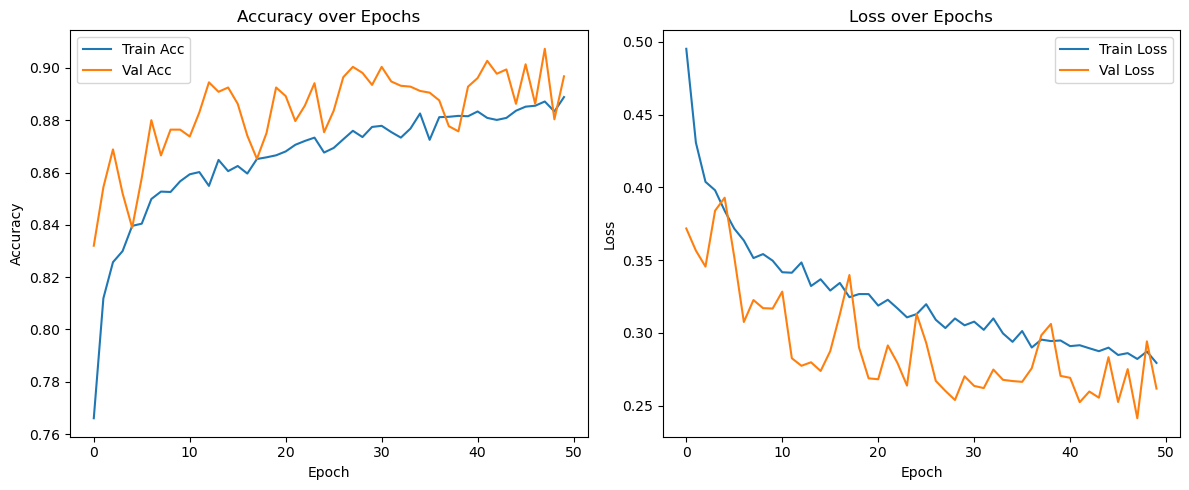

In [147]:
# ------------------- Evaluation -------------------
# Accuracy & Loss plots
def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
               precision    recall  f1-score   support

Not Cancerous       0.94      0.89      0.91      1981
    Cancerous       0.81      0.90      0.85      1061

     accuracy                           0.89      3042
    macro avg       0.87      0.89      0.88      3042
 weighted avg       0.89      0.89      0.89      3042



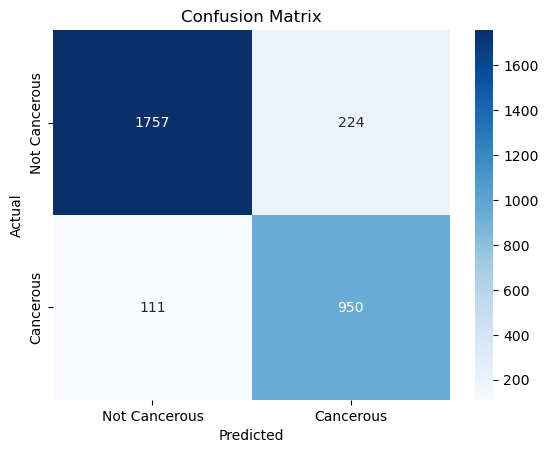

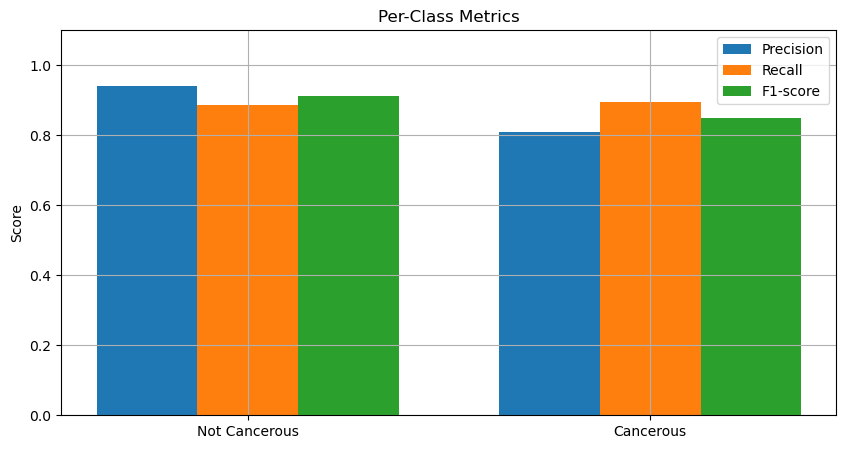

In [154]:
y_probs = model_t1.predict(test_images_t1)
y_pred_final = (y_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test_t1, y_pred_final, target_names=["Not Cancerous", "Cancerous"]))

# Confusion Matrix
cm = confusion_matrix(y_test_t1, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Cancerous", "Cancerous"], yticklabels=["Not Cancerous", "Cancerous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Per-class precision/recall/F1
def plot_precision_recall_f1(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}

    plt.figure(figsize=(10, 5))
    for i, (metric, values) in enumerate(metrics.items()):
        plt.bar(np.arange(len(values)) + i*0.25, values, width=0.25, label=metric)
    
    plt.xticks(np.arange(len(class_names)) + 0.25, class_names)
    plt.ylim(0, 1.1)
    plt.ylabel("Score")
    plt.title("Per-Class Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_f1(y_test_t1, y_pred_final, ["Not Cancerous", "Cancerous"])

## **Results and Performance Analysis**

- The CNN trained smoothly, with no signs of overfitting due to dropout and data augmentation.
- Class weights contributed to higher cancerous recall by emphasizing learning from minority samples.
- Early stopping based on validation recall ensured the model prioritized **detecting cancerous cases consistently**.
- We used a **default threshold of 0.5**, relying on the recall-focused training setup to still capture most cancer cases.

### **Performance Metrics**

| Class         | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| Not Cancerous | 0.94      | 0.89   | 0.91     | 1981    |
| Cancerous     | 0.81      | 0.90   | 0.85     | 1061    |

- **Accuracy**: 89%  
- **Macro Avg F1-score**: 0.88  
- **Weighted Avg F1-score**: 0.89  

### **Interpretation**

- **Cancerous recall = 0.90** — this is a key success metric. The model correctly detects 90% of actual cancerous images, which is vital for clinical safety.
- While **precision for cancerous (0.81)** is lower, this is a **deliberate trade-off**:
  - In a real-world deployment, **false positives** can be manually reviewed by healthcare professionals.
  - **False negatives**, on the other hand, pose a serious risk by missing critical cases — hence the focus on recall.
- This model can serve as a **first-stage screening tool** to flag potentially cancerous samples early.
---